In [1]:
from google.colab import drive
drive.mount('/drive')
%cd /drive/My Drive/notebooks

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
/drive/My Drive/notebooks


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np
import random
import math

In [3]:
DATA_PATH = './data'
log_PATH = "./logs/"
modelName = "MNIST_InfoGAN"
batch_size = 128
workers = 2
epochs = 20

category_c  = 10
continuous_c = 2

latent_c = category_c+continuous_c # 10 category + 2 continuous latent codes

latent_z=62

gf_dim = 64
df_dim = 64

in_h = 28
in_w =28
c_dim = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

manualSeed = 3734
print("Random Seed: ",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  3734


In [0]:
transform = transforms.Compose(
    [
     transforms.Resize((in_h,in_w)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,)),
     ]
)


def transform_inverse (y):
  t= None
  if y.size()[0]==1:
    t=torchvision.transforms.Normalize((-1,),(2,))
  else :
    t=torchvision.transforms.Normalize((-1,-1,-1),(2,2,2))
  return t(y)

def batch_transform_inverse(y):
  x = y.new(*y.size())
  if y.size()[1]==1:
    x[:, 0, :, :] = y[:, 0, :, :] * 2 - 1
  else:
    x[:, 0, :, :] = y[:, 0, :, :] * 2 - 1
    x[:, 1, :, :] = y[:, 1, :, :] * 2 - 1 
    x[:, 2, :, :] = y[:, 2, :, :] * 2 - 1
  return x

In [0]:
train_set = torchvision.datasets.MNIST(root=DATA_PATH,train=True,
                                      download=True,transform=transform)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,
                                          shuffle =True, num_workers=workers)

test_set = torchvision.datasets.MNIST(root=DATA_PATH,train=False,
                                     download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle = False, num_workers=workers)

train_iter = iter(train_loader)
test_iter = iter(test_loader)

torch.Size([1, 28, 28])


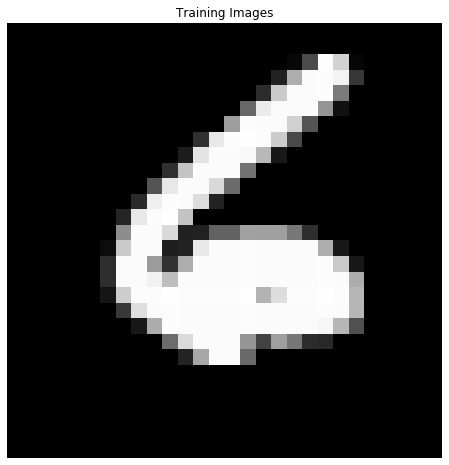

In [6]:
real_batch, label = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2, normalize=True).cpu(),(1,2,0)))

print(real_batch[0].size())

In [0]:
def conv_bn_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
        nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
    )
def tconv_bn_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
      nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
  )
def tconv_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
  return nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding)

def conv_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
    return nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding)

def conv_lrelu_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
  )

def fc_layer(in_features,out_features):
  return nn.Linear(in_features,out_features)

def fc_bn_layer(in_features,out_features):
  return nn.Sequential(
      nn.Linear(in_features,out_features),
      nn.BatchNorm1d(out_features)
  )


In [0]:
def conv_out_size_same(size, stride):
  return int(math.ceil(float(size) / float(stride)))
s_h, s_w = in_h, in_w
s_h2, s_w2 = conv_out_size_same(s_h, 2), conv_out_size_same(s_w, 2)
s_h4, s_w4 = conv_out_size_same(s_h2, 2), conv_out_size_same(s_w2, 2)
s_h8, s_w8 = conv_out_size_same(s_h4, 2), conv_out_size_same(s_w4, 2)
s_h16, s_w16 = conv_out_size_same(s_h8, 2), conv_out_size_same(s_w8, 2)

In [0]:
def gaussianSampler(mean, std,device):
  epsilon=torch.randn(mean.size(),device=device)
  return mean + epsilon*std

def categoricalSampler(probs):
  dists = torch.distributions.multinomial.Multinomial(1,probs)
  return dists.sample().to(device)


def latent_sample_prior(batch_size,device,category=None):
  z = torch.rand(batch_size, latent_z,device=device)*2-1 # Uniform[-1,1] prior

  if category is None:
    label_idx = torch.randint(low=0,high=9,size=(batch_size,))
  else:
    label_idx = category
  c_cate = torch.zeros((batch_size,category_c),device=device)
  for i in range(batch_size):
    c_cate[i][label_idx[i]]=1.0
  c1_cont=torch.rand(batch_size, 1,device=device)*2-1 # Uniform[-1,1] prior
  c2_cont=torch.rand(batch_size, 1,device=device)*2-1 # Uniform[-1,1] prior 
  c = torch.cat((c_cate,c1_cont,c2_cont),dim=1)
 
  return torch.cat((z,c),dim=1), label_idx

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.fc_bn_layer1 = fc_bn_layer(latent_z+latent_c,1024)
    self.fc_layer2 = fc_layer(1024,s_h4*s_w4*128)
    self.bn_layer2 = nn.BatchNorm2d(128)
    self.upconv_bn_layer3 = tconv_bn_layer(128,64,4,2,1)
    self.upconv_layer4 = tconv_layer(64,1,4,2,1)
    self.tanh = nn.Tanh()

  def forward(self, x): 
    x = F.relu(self.fc_bn_layer1(x)) # c+z -> 1024
    x = self.bn_layer2(F.relu(self.fc_layer2(x)).view(-1,128,s_h4,s_w4)) # 1024 -> 128x7x7
    x = F.relu(self.upconv_bn_layer3(x)) # 128x7x7 -> 64x14x14
    x = self.upconv_layer4(x) # 28x28

    return self.tanh(x)

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.conv_layer1 = conv_layer(c_dim,df_dim,4,2,1)
    self.conv_bn_layer2 = conv_bn_layer(df_dim,df_dim*2,4,2,1)
    self.fc_layer3 =  fc_layer(128*7*7,1024) 
    self.bn_layer3 = nn.BatchNorm1d(1024)
    
    self.fc_d_layer4 = fc_layer(1024,1)
    self.sigmoid =nn.Sigmoid()

    self.fc_bn_layer4 = fc_bn_layer(1024,128)
    self.fc_bn_q_layer5 = fc_layer(128,latent_c) # 10+2
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x):
    x = F.leaky_relu(self.conv_layer1(x),0.1)# 1x28x28 -> 64x14x14 
    x = F.leaky_relu(self.conv_bn_layer2(x),0.1)# 64x14x14 -> 128x7x7
    x = self.bn_layer3(F.leaky_relu(self.fc_layer3(torch.flatten(x,1))))# 128x7x7 -> 1024

    D = self.sigmoid(self.fc_d_layer4(x)).squeeze()#1024 -> 1

    Q = self.fc_bn_q_layer5(F.leaky_relu(self.fc_bn_layer4(x),0.1))# 1024 -> 128 -> c
    
    soft_cate = self.softmax(Q[:,:category_c]) # 10 discrete in 12 
    c_cate = categoricalSampler(soft_cate)

    mu = Q[:,category_c:] # 2 parmeters of distribution in 12
    std = torch.ones_like(mu)
    c_cont=gaussianSampler(mu,std,device=device)

    c=torch.cat((c_cate,c_cont),dim=1)

    return D, c, soft_cate, mu, std

In [0]:
class NormalNLLLoss:
    """
    Calculate the negative log likelihood
    of normal distribution.
    This needs to be minimised.
    Treating Q(cj | x) as a factored Gaussian.
    """
    def __call__(self, x, mu, var):
        
        logli = -0.5 * (var.mul(2 * np.pi) + 1e-6).log() - (x - mu).pow(2).div(var.mul(2.0) + 1e-6) 
        nll = -(logli.sum(1).mean())

        return nll

In [0]:
import torch.optim as optim

G_net = Generator().to(device)
D_net = Discriminator().to(device)

criterion_D = nn.BCELoss()
criterion_Q_cate = nn.NLLLoss()
criterion_Q_cont = NormalNLLLoss() # Todo fix

G_optimizer = optim.Adam(G_net.parameters(),lr=1e-3,betas=(0.5,0.999))
D_optimizer = optim.Adam(D_net.parameters(),lr=2e-4,betas=(0.5,0.999))

real_label = 1
fake_label = 0


fixed_noise, fixed_label = latent_sample_prior(batch_size,device)
fixed_noise_0, fixed_label_0 = latent_sample_prior(batch_size,device,torch.ones((batch_size,),dtype=torch.long)*0)
fixed_noise_1, fixed_label_1 = latent_sample_prior(batch_size,device,torch.ones((batch_size,),dtype=torch.long)*1)
fixed_noise_2, fixed_label_2 = latent_sample_prior(batch_size,device,torch.ones((batch_size,),dtype=torch.long)*2)
fixed_noise_3, fixed_label_3 = latent_sample_prior(batch_size,device,torch.ones((batch_size,),dtype=torch.long)*3)
fixed_noise_4, fixed_label_4 = latent_sample_prior(batch_size,device,torch.ones((batch_size,),dtype=torch.long)*4)
fixed_noise_5, fixed_label_5 = latent_sample_prior(batch_size,device,torch.ones((batch_size,),dtype=torch.long)*5)

In [14]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv')!=-1 or classname.find('Linear')!=-1:
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('BatchNorm')!=-1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)

print(G_net.apply(weights_init))
print(D_net.apply(weights_init))

Generator(
  (fc_bn_layer1): Sequential(
    (0): Linear(in_features=74, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_layer2): Linear(in_features=1024, out_features=6272, bias=True)
  (bn_layer2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (upconv_bn_layer3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (upconv_layer4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (tanh): Tanh()
)
Discriminator(
  (conv_layer1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_bn_layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_layer3)

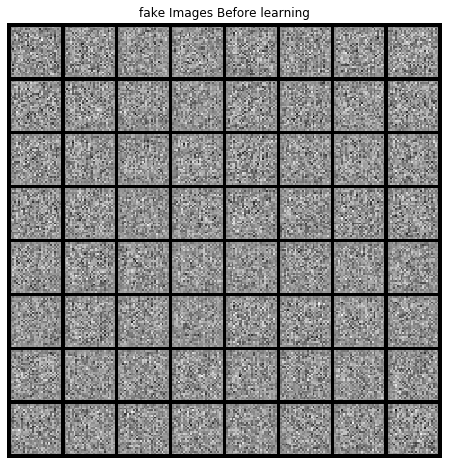

In [15]:
with torch.no_grad():
  fake_batch=G_net(fixed_noise)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('fake Images Before learning')
plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device)[:64].view(64,c_dim,in_h,in_w),padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
img_list = []
G_losses = []
D_losses = []

iter_per_plot = 250
plot_per_eps=(int(len(train_loader)/iter_per_plot)+1)

transform_PIL=transforms.ToPILImage()


In [0]:
for ep in range(epochs):
  for i, (data, labels) in enumerate(train_loader):
    b_size=data.shape[0]

    data = data.to(device)
    real_label = torch.ones(b_size).to(device)
    fake_label = torch.zeros(b_size).to(device)

    #Train on real data
    #Train D based on real
    D_net.zero_grad()
    real_d, _, _, _, _=D_net(data)

    loss_D_real = criterion_D(real_d,real_label)

    #Train on fake data
    #Train D based on G
    z_var, fake_indices=latent_sample_prior(b_size,device)
    fake_images = G_net(z_var)
    fake_d, samples, soft_cate, q_mu, q_std= D_net(fake_images.detach())

    loss_D_fake=criterion_D(fake_d,fake_label)
    
    # D_optimizer.step()

    #Train G based on D
    G_net.zero_grad()
    fake_d, _, soft_cate, mu, std= D_net(fake_images)
    loss_G_d = criterion_D(fake_d,real_label)


    #Train G based on Q
    target=torch.LongTensor(fake_indices).to(device)

    loss_Q_cont = criterion_Q_cate(soft_cate,target)

    loss_Q_cate = criterion_Q_cont(z_var[:,latent_z+category_c:],q_mu,q_std**2)

    loss_Q = loss_Q_cate + loss_Q_cont

    loss_D = loss_D_real + loss_D_fake + loss_Q
    loss_D.backward(retain_graph=True)
    D_optimizer.step()

    loss_G = loss_G_d + loss_Q
    loss_G.backward()
    G_optimizer.step()

    if (i+1)%iter_per_plot == 0 or i ==0:
      print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, Q_loss: {:.4f},g_loss: {:.4f}' 
            .format(ep, epochs, i+1, len(train_loader), loss_D.item(), loss_Q.item(),loss_G.item()))
      G_losses.append(loss_G.item())
      D_losses.append(loss_D.item())
      if (i+1)%iter_per_plot*4 or i == 0 :
        with torch.no_grad():
          fake = G_net(fixed_noise).detach().cpu()
          img_list.append(vutils.make_grid(torch.reshape(fake,(b_size,c_dim,in_h,in_w))[:64], padding=2, normalize=True))
          transform_PIL(img_list[-1]).save(log_PATH+str(ep)+modelName+"_Last.png")

In [0]:
with torch.no_grad():
  fake_batch=G_net(fixed_noise)
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('fake Images')
plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device)[:64].view(64,c_dim,in_h,in_w),padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [0]:
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [0]:
from PIL import Image
transform_PIL=transforms.ToPILImage()

p_img_list = [transform_PIL(p_image) for p_image in img_list]
p_img_list[0].save(log_PATH+modelName+'.gif', save_all=True,append_images=p_img_list[1:], optimize=False, duration=0.5, loop=0)

In [0]:
p_img_list[-1].save(log_PATH+modelName+"_last_result.png")

In [0]:
with torch.no_grad():
  random_noise=torch.randn(1,latent_z,device=device)
  fake=G_net(random_noise)
fake = fake.squeeze().cpu().view(c_dim,in_h,in_w)
fake_image=transform_inverse(fake)
plt.axis("off")
if fake_image.size()[0]==3:
  plt.imshow(np.transpose(fake_image,(1,2,0)))
else:
  plt.imshow(fake_image.squeeze(),cmap='gray')

In [0]:
plt.title("Losses")
epsilon = 1/plot_per_eps
X = np.array(range(plot_per_eps*epochs))/plot_per_eps

plt.plot(X,G_losses,label="G loss")
plt.plot(X,D_losses,label="D loss")
plt.legend(loc=2)
plt.xticks(np.arange(0,epochs+1,5)) 
plt.ylabel("V(D,G)")
plt.xlabel("Epochs")
#plt.show()
plt.savefig(modelName+"_loss_figure.png")

In [0]:
torch.save(G_net.state_dict(),log_PATH+"G_"+modelName+".pth")

In [0]:
G_net.load_state_dict(torch.load(log_PATH+"G_"+modelName+".pth"))

In [0]:
torch.save(D_net.state_dict(),log_PATH+"D_"+modelName+".pth")

In [0]:
D_net.load_state_dict(torch.load(log_PATH+"D_"+modelName+".pth"))